In [1]:
run_in_notebook = True

In [2]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')

from decode_tueg import decode_tueg

In [3]:
import time
import logging

from sklearn.model_selection import ParameterGrid, ParameterSampler
import pandas as pd

In [4]:
import os
import glob
import datetime
from typing import List
from functools import reduce

import json
from kfp import Client
from kfp.compiler import Compiler
from kfp.components import (
    create_component_from_func, load_component_from_text, OutputPath)
from kfp.dsl import (
    PipelineParam, PipelineVolume, pipeline as dsl_pipeline, RUN_ID_PLACEHOLDER)
from kubernetes.client.models.v1_toleration import V1Toleration
from kubernetes.client import V1EmptyDirVolumeSource, V1Volume
client = Client()

In [5]:
import torch
torch.version.cuda

'11.3'

In [6]:
pipe_suffix = 'decode_age'

In [7]:
job_definition = """
name: TUAB age decoding
inputs:
- name: augment
  type: String
- name: batch_size
  type: Integer
- name: data_path
  type: String
- name: debug
  type: Integer
- name: fast_mode
  type: Integer
- name: final_eval
  type: Integer
- name: intuitive_training_scores
  type: Integer
- name: loss
  type: String
- name: model_name
  type: String
- name: n_epochs
  type: Integer
- name: n_jobs
  type: Integer
- name: n_restarts
  type: Integer
- name: n_train_recordings
  type: Integer
- name: out_dir
  type: String
- name: preload
  type: Integer
- name: seed
  type: Integer
- name: shuffle_data_before_split
  type: Integer
- name: split_kind
  type: String
- name: squash_outs
  type: Integer
- name: standardize_data
  type: Integer
- name: standardize_targets
  type: Integer
- name: subset
  type: String
- name: target_name
  type: String
- name: tmax
  type: Integer
- name: tmin
  type: Integer
- name: valid_set_i
  type: Integer
- name: window_size_samples
  type: Integer
- name: run_name
  type: String
  
  
implementation:
    container:
        # This is using a development version of the job executor, which might 
        # unexpectedly change,
        # You probably want to got to https://cr.nail.science and pick the latest
        # stable tag, e.g. v1.0.0, to use in your experiments.
        image: cr.nail.science/ml-containers/python-job:git-6d43792
        command: ['/init', 'python', 'tueg_age_decoding/decode_tueg.py']
        args: [
            '--augment', {inputValue: augment},
            '--batch-size', {inputValue: batch_size},
            '--data-path', {inputValue: data_path},
            '--debug', {inputValue: debug},
            '--fast-mode', {inputValue: fast_mode},
            '--final-eval', {inputValue: final_eval},
            '--intuitive-training-scores', {inputValue: intuitive_training_scores},
            '--loss', {inputValue: loss},
            '--model-name', {inputValue: model_name},
            '--n-epochs', {inputValue: n_epochs},
            '--n-jobs', {inputValue: n_jobs},
            '--n-restarts', {inputValue: n_restarts},
            '--n-train-recordings', {inputValue: n_train_recordings},
            '--out-dir', {inputValue: out_dir},
            '--preload', {inputValue: preload},
            '--seed', {inputValue: seed},
            '--shuffle-data-before-split', {inputValue: shuffle_data_before_split},
            '--split-kind', {inputValue: split_kind},
            '--squash-outs', {inputValue: squash_outs},
            '--standardize-data', {inputValue: standardize_data},
            '--standardize-targets', {inputValue: standardize_targets},
            '--subset', {inputValue: subset},
            '--target-name', {inputValue: target_name},
            '--tmax', {inputValue: tmax},
            '--tmin', {inputValue: tmin},
            '--valid-set-i', {inputValue: valid_set_i},
            '--window-size-samples', {inputValue: window_size_samples},
            '--run-name', {inputValue: run_name},
        ]
"""

In [8]:
f"{client.get_user_namespace()}-{pipe_suffix}"

'kf-gemein-lukas-decode_age'

In [9]:
@dsl_pipeline(name=f"{client.get_user_namespace()}-{pipe_suffix}")
def demo_pipeline(
    augment:str,
    batch_size:int,
    data_path:str,
    debug:int,
    fast_mode:int,
    final_eval:int,
    intuitive_training_scores:int,
    loss:str,
    model_name:str,
    n_epochs:int,
    n_jobs:int,
    n_restarts:int,
    n_train_recordings:int,
    out_dir:str,
    preload:int,
    seed:int,
    shuffle_data_before_split:int,
    split_kind:str,
    squash_outs:int,
    standardize_data:int,
    standardize_targets:int,
    subset:str,
    target_name:str,
    tmax:int,
    tmin:int,
    valid_set_i:int,
    window_size_samples:int,
    run_id:str=RUN_ID_PLACEHOLDER,
):
    workspace = PipelineVolume(pvc=f'workspace-tueg')
    mne_data = PipelineVolume(pvc='mne-data')
    shared_volume = PipelineVolume(volume=V1Volume(
        name="shm",
        empty_dir=V1EmptyDirVolumeSource(medium='Memory')))
    
    run_name = f"decode_age"
    # on disk, preprocessed TUHAbnormal is 17GB
    mem_lim = '20Gi'
    mem_req = '20Gi'

    (load_component_from_text(job_definition)(
        augment=augment,
        batch_size=batch_size,
        data_path=data_path,
        debug=debug,
        fast_mode=fast_mode,
        final_eval=final_eval,
        intuitive_training_scores=intuitive_training_scores,
        loss=loss,
        model_name=model_name,
        n_epochs=n_epochs,
        n_jobs=n_jobs,
        n_restarts=n_restarts,
        n_train_recordings=n_train_recordings,
        out_dir=out_dir,
        preload=preload,
        seed=seed,
        shuffle_data_before_split=shuffle_data_before_split,
        split_kind=split_kind,
        squash_outs=squash_outs,
        standardize_data=standardize_data,
        standardize_targets=standardize_targets,
        subset=subset,
        target_name=target_name,
        tmax=tmax,
        tmin=tmin,
        valid_set_i=valid_set_i,
        window_size_samples=window_size_samples,
        run_name=run_name,
    )
    .add_pvolumes({
        '/work': workspace,
        '/home/jovyan/mne_data': mne_data,
        '/dev/shm': shared_volume,
    })
    # If you do not add this, your job will download all the packages on every run. 
    # Which will be veery slow and congest our network ...
    .add_pod_label('shared-package-cache', 'true')
    # Request the required resources
    .set_cpu_limit('6')
    .set_cpu_request('6')
    .set_memory_limit(mem_lim)
    .set_memory_request(mem_req)
    # This is needed so your job can be scheduled on GPU nodes 
    .add_toleration(
        V1Toleration(key='nvidia.com/gpu', operator='Exists', effect='NoSchedule'))
    .set_gpu_limit('1')
    )

In [10]:
yml_file = '/home/jovyan/workflow.yaml'
pipeline_name = f"{client.get_user_namespace()}-{pipe_suffix}"

In [11]:
pipeline_name

'kf-gemein-lukas-decode_age'

In [12]:
Compiler().compile(demo_pipeline, yml_file)

In [13]:
pipeline_id = client.get_pipeline_id(pipeline_name)
if pipeline_id is not None:
    pipeline = client.get_pipeline(pipeline_id)
    pipline = client.upload_pipeline_version(
        yml_file, pipeline_id=pipeline_id, 
        pipeline_version_name=datetime.datetime.now().isoformat())
else:
    pipeline = client.upload_pipeline(yml_file, pipeline_name=pipeline_name)

In [14]:
pipeline_name

'kf-gemein-lukas-decode_age'

In [ ]:
try:
    experiment = client.get_experiment(experiment_name=pipe_suffix)
except ValueError:
    experiment = client.create_experiment(pipe_suffix)

In [6]:
if run_in_notebook:
    out_dir = '/home/jovyan/outdated_runs/'  #full_runs/'
else:
    out_dir = '/work/new_full_runs/'

In [7]:
param_grid = ParameterGrid({
    'model_name': ['tcn'],  # 'shallow', 'deep', 'tcn'
    'subset': ['normal'],  # 'normal', 'abnormal', 'mixed'
    'target_name': ['age'],  # age, gender, pathological, age_clf

    'valid_set_i': [0],  # 0, 1, 2, 3, 4
    'n_epochs': [3],  # 35, 105, 210
    'n_restarts': [0],  # 0, 2, 5
    'augment': ['random'],  # dropout, flipfb, fliplr, noise, mask, reverse, shuffle, sign, random, identity
    'fast_mode': [1],
    'loss': ['mse'],  # mse, mae, log_cosh, huber, nll

    'n_train_recordings': [100],  # -1: None
    'tmax': [2*60],  # 4*60done, 6*60done, 11*60done, -1,  # -1: None
    'data_path': ['/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal/v2.0.0/edf/'],
    'split_kind': ['age_distribution'],  # chronological, random, age_distribution
    'squash_outs': [1],  # force output to be in [0, 1] through sigmoid

    'final_eval': [0],
    'debug': [1],
    'seed': [20220429],
    'intuitive_training_scores': [1],  # 1: add slow callbacks that track age decodnig loss intuitively as mae
    'out_dir': [out_dir],
    'n_jobs': [6],  # faster than 1, 3, and 4 on tmax=2*60, n_recordings=-1, subset=normal, n_epochs=5, preload=0
    'preload': [0],

    'batch_size': [64],  # 64. does CroppedTrialEpochStoring increase GPU memory consumption? 256 works fine in notebook but fails as pipeline. 128 works with shallow fails with deep
    'tmin': [1*60],
    'standardize_data': [1],
    'standardize_targets': [1],
    'window_size_samples': [6000],
    'shuffle_data_before_split': [0],
})

In [8]:
len(param_grid)

1

2022-09-01 14:10:48 INFO     
augment                                                                 random
batch_size                                                                  64
data_path                    /home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...
debug                                                                        1
fast_mode                                                                    1
final_eval                                                                   0
intuitive_training_scores                                                    1
loss                                                                       mse
model_name                                                                 tcn
n_epochs                                                                     3
n_jobs                                                                       6
n_restarts                                                                   0
n_train_recordings    

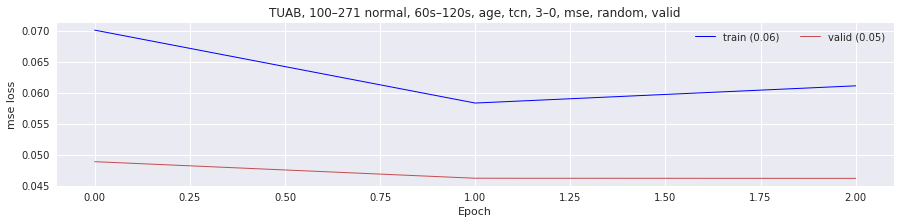

In [9]:
if run_in_notebook:
    for params_i, params in enumerate(param_grid):
        # logging makes the second iteration crash....
        decode_tueg(**params, config=pd.Series(params, name='config'))
else:
    #now = datetime.datetime.now().isoformat()
    now = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M')
    runs = []
    for params in param_grid:
        run = client.run_pipeline(    
            experiment_id=experiment.id, 
            pipeline_id=pipeline.id, 
            job_name=f"{pipe_suffix}-{now}-{params['seed']}-{params['valid_set_i']}",
            params=params,
        )
        runs.append(run)
        time.sleep(1)

In [10]:
print("hi")

hi


In [21]:
import json

In [22]:
json.dumps(params)

'{"augment": "random", "batch_size": 64, "data_path": "/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal/v2.0.0/edf/", "debug": 1, "fast_mode": 1, "final_eval": 0, "intuitive_training_scores": 1, "loss": "huber", "model_name": "tcn", "n_epochs": 35, "n_jobs": 6, "n_restarts": 0, "n_train_recordings": -1, "out_dir": "/work/new_full_runs/", "preload": 0, "seed": 20220429, "shuffle_data_before_split": 0, "split_kind": "age_distribution", "squash_outs": 1, "standardize_data": 1, "standardize_targets": 1, "subset": "normal", "target_name": "age", "tmax": -1, "tmin": 60, "valid_set_i": 0, "window_size_samples": 6000}'

In [23]:
json.loads(json.dumps(params))

{'augment': 'random',
 'batch_size': 64,
 'data_path': '/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal/v2.0.0/edf/',
 'debug': 1,
 'fast_mode': 1,
 'final_eval': 0,
 'intuitive_training_scores': 1,
 'loss': 'huber',
 'model_name': 'tcn',
 'n_epochs': 35,
 'n_jobs': 6,
 'n_restarts': 0,
 'n_train_recordings': -1,
 'out_dir': '/work/new_full_runs/',
 'preload': 0,
 'seed': 20220429,
 'shuffle_data_before_split': 0,
 'split_kind': 'age_distribution',
 'squash_outs': 1,
 'standardize_data': 1,
 'standardize_targets': 1,
 'subset': 'normal',
 'target_name': 'age',
 'tmax': -1,
 'tmin': 60,
 'valid_set_i': 0,
 'window_size_samples': 6000}